### Operator Learning: Solving a ODE for different right hand sides

In this notebook, we present an introduction to the operator learning utilities of TorchPhysics. 
As an example, we start easy and try to learn the integral operator of the ODE:
\begin{align*}
    \partial_t u(t) &= 5.0f(t), \text{ in } (0, 1) \\
    u(0) &= 0
\end{align*}
for different functions $f$. We will use the Deep Operator Networks (DeepONet) [(paper)](https://arxiv.org/abs/2103.10974) to solve this problem.

In [1]:
import os, sys
sys.path.append(os.getcwd())

import torch 
import torchphysics as tp
import pytorch_lightning as pl
import matplotlib.pyplot as plt

In [2]:
save_path = "/localdata/tomfre/DeepONet_data_integrator"
input_t = torch.load(f"{save_path}/input_t.pt")
input_f = torch.load(f"{save_path}/input_f.pt")
output_u = torch.load(f"{save_path}/output_u.pt")

print("Time discretization:", len(input_t))
print("Available data points:", len(input_f))
print("Shape of data:", input_f.shape)

Time discretization: 100
Available data points: 20000
Shape of data: torch.Size([20000, 100, 1])


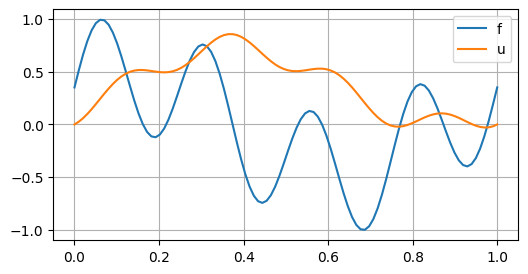

In [3]:
example_idx = 1902
plt.figure(0, figsize=(6, 3))
plt.plot(input_t, input_f[example_idx])
plt.plot(input_t, output_u[example_idx])
plt.grid()
leg = plt.legend(["f", "u"])

In [4]:
T = tp.spaces.R1("t")
F = tp.spaces.R1("f")
U = tp.spaces.R1("u")

I_t = tp.domains.Interval(T, 0, 1)

fn_space_F = tp.spaces.FunctionSpace(T, F)
fn_space_U = tp.spaces.FunctionSpace(T, U)

In [5]:
# Split data into training and testing:
total_data = len(input_f)
train_N = int(0.8*total_data)

train_f = input_f[:train_N]
train_u = output_u[:train_N]

test_f = input_f[train_N:]
test_u = output_u[train_N:]

# Define FunctionSet (DataSet)
data_functionset_input = tp.domains.DataFunctionSet(fn_space_F, train_f)

In [6]:
functionsampler_input = tp.samplers.FunctionSamplerRandomUniform(6000, data_functionset_input)

time_sampler = tp.samplers.DataSampler(tp.spaces.Points(input_t, T))
initial_sampler = tp.samplers.RandomUniformSampler(I_t.boundary_left, 1)

In [7]:
### DeepONet
trunk_net = tp.models.FCTrunkNet(T, default_trunk_input=input_t, hidden=(30, 30, 30))
branch_net = tp.models.FCBranchNet(fn_space_F, hidden=(50, 50, 50), grid=input_t)
model = tp.models.DeepONet(trunk_net, branch_net, U, output_neurons=50)

In [8]:
def ode_residual(u, t, f):
    return tp.utils.grad(u, t) - 5.0*f

ode_cond = tp.conditions.PIDeepONetCondition(deeponet_model=model, 
                                             branch_function_sampler=functionsampler_input, 
                                             trunk_points_sampler=time_sampler, 
                                             residual_fn=ode_residual)

In [9]:
def initial_residual(u):
    return u

initial_cond = tp.conditions.PIDeepONetCondition(deeponet_model=model, 
                                              branch_function_sampler=functionsampler_input, 
                                              trunk_points_sampler=initial_sampler, 
                                              residual_fn=initial_residual)

In [10]:
lr_scheduler = torch.optim.lr_scheduler.StepLR

optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.01,
                            scheduler_class=lr_scheduler, 
                            scheduler_args={"step_size": 2500, "gamma":0.2})
solver = tp.solver.Solver([ode_cond, initial_cond], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                    num_sanity_val_steps=0,
                    benchmark=True,
                    max_steps=20000, 
                    logger=False, 
                    enable_checkpointing=False)

trainer.fit(solver)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/tomfre/miniconda3/envs/tp_version2/lib/python3.11/site-packages/pytorch_lightning/core/optimizer.py:256: Found unsupported keys in the lr scheduler dict: {'step_size', 'gamma'}. HINT: remove them from the output of `configure_optimizers`.

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 16.2 K
1 | val_conditions   | ModuleList | 0     
-----------

Epoch 0: 100%|██████████| 20000/20000 [06:58<00:00, 47.76it/s, train/loss=0.147]

`Trainer.fit` stopped: `max_steps=20000` reached.


Epoch 0: 100%|██████████| 20000/20000 [06:58<00:00, 47.75it/s, train/loss=0.147]


In [11]:
model_output = model(branch_inputs=tp.spaces.Points(test_f, F)).as_tensor.detach()
rel_error = torch.max(torch.abs(model_output - test_u)) / torch.max(torch.abs(test_u))
print(f"Relative error on test data: {rel_error*100} %")

Relative error on test data: 1.4570025205612183 %


Example plot:


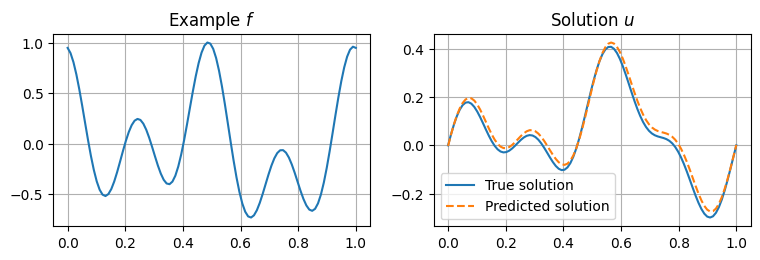

In [12]:
print("Example plot:")
plot_idx = 620
f, axarr = plt.subplots(1,2, figsize=(9, 2.5))
axarr[0].plot(input_t, test_f[plot_idx])
axarr[0].title.set_text(r"Example $f$")
axarr[0].grid()
axarr[1].plot(input_t, test_u[plot_idx])
axarr[1].plot(input_t, model_output[plot_idx], linestyle="--")
axarr[1].title.set_text(r"Solution $u$")
axarr[1].grid()
leg = axarr[1].legend(["True solution", "Predicted solution"])

